In [1]:
%load_ext autoreload
%autoreload 2

# Tutorial: STHD Training

This is an end-to-end tutorial to demonstrate how to fit the STHD model on a given Visium HD patch. 
The raw visium HD data usually contains millions of spots and is too large to train in a single pass. In this quick demonstration, we used a patch of the raw VisiumHD data.
We will load the patch using STHDio and run training on the patch.

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import squidpy as sq

# add STHD path
sys.path.append('../')
from STHD import qcmask
from STHD import train
from STHD import color_palette

# (pip version to be published)
# pip install STHD

# 1. Load a processed sample VisiumHD patch, and also load a pre-processed gene by cell type reference file.

In [3]:
testdata_path = '/hpc/group/yizhanglab/DATA/zs144/STHD/testdata/'

In [4]:
########## crop10 path 
patch_path = os.path.join(testdata_path, 'crop10/')
refile = os.path.join(testdata_path, 'crc_average_expr_genenorm_lambda_98ct_4618gs.txt')

# # (optional) Obtain a VisiumHD patch from original full data and put in testdata
# from STHD import sthdio

# hd_data_square_002um_path = '../testdata/VisiumHD/square_002um/' # shall contain filtered_feature_bc_matrix.h5 
# hd_fullres_img_btf_path = '../testdata/VisiumHD/Visium_HD_Human_Colon_Cancer_tissue_image.btf'

# full_data = sthdio.STHD(
#     spatial_path = hd_data_square_002um_path, 
#     counts_data = 'filtered_feature_bc_matrix.h5', 
#     full_res_image_path = hd_fullres_img_btf_path, 
#     load_type = 'original'
# )

# # crop10: tumor epithelial
# x1 = 56250
# y1 = 8250
# d = 1100
# x2 = x1+d
# y2 = y1+d
# crop_data = full_data.crop(
#     x1, x2, y1, y2, 
#     full_data.adata.uns['spatial']['Visium_HD_Human_Colon_Cancer']['scalefactors']['tissue_hires_scalef']
# )
# crop_data.save('../testdata/crop10')

In [5]:
from STHD import train
# load training data
sthdata = train.load_data(patch_path)
sthdata.adata.var_names_make_unique()
print('Spot x gene :')
print(sthdata.adata.shape)

print('Coordinates of this crop in full-reso image coords in ( x1, y1, x2, y2 ):')
coords = sthdata.get_sequencing_data_region()
print(f'{coords}')

[log] Number of spots:  22336
Spot x gene :
(22336, 18085)
Coordinates of this crop in full-reso image coords in ( x1, y1, x2, y2 ):
(56250, 8240, 57340, 9330)


/hpc/group/yizhanglab/zs144/miniconda3/envs/STHD/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Check data

- Scanpy/Squidpy object
- Read counts
- Some genes

In [6]:
sthdata.adata

AnnData object with n_obs × n_vars = 22336 × 18085
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [7]:
# Subset a partial view and convert it to a pd.DataFrame for better viewing.
sthdata.adata[:5, ["SAMD11", "NOC2L"]].to_df()

,SAMD11,NOC2L
s_002um_01855_02181-1,0.0,0.0
s_002um_01822_02261-1,0.0,0.0
s_002um_01913_02137-1,0.0,0.0
s_002um_01891_02172-1,0.0,0.0
s_002um_01921_02251-1,0.0,0.0


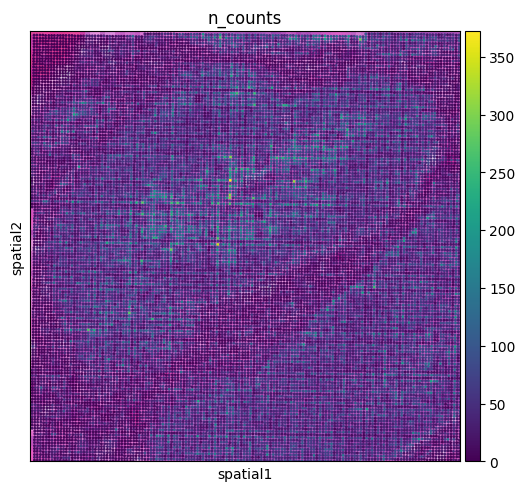

In [8]:
# Add up the counts of all genes at each spatial coordinate and visualie them.
sthdata.adata.obs['n_counts'] = sthdata.adata.X.sum(axis=1)
sq.pl.spatial_scatter(sthdata.adata, crop_coord = coords , color = 'n_counts')

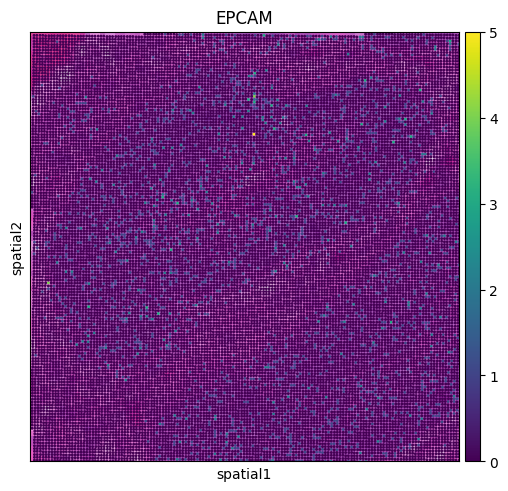

In [9]:
# Select the "EPCAM" gene and visualize its counts at each coordinate.
# sthdata.adata[:, ["EPCAM"]].to_df()
sq.pl.spatial_scatter(sthdata.adata, crop_coord = coords , color = 'EPCAM')

# 2. Patch training

## Fixed best parameters for colon cancer sample

In [10]:
n_iter = 20
beta = 0.1
step_size = 1 # fix

## STHD Training
- Will filter low-count region, train (printing loss for 23 steps), and extract results

In [ ]:
# Option 1: qc mask to filter low counts
# sthdata.adata = qcmask.background_detector(sthdata.adata, threshold=50, n_neighs=4, n_rings=2)
# print('sthdata shape:', sthdata.adata.shape)

# Option 2: provide a separate mask
sthdata_filtered = qcmask.filter_background(sthdata, threshold=50)
print('filtered sthdata shape:',sthdata_filtered.adata.shape)

# match with the cell type reference genes
sthdata_filtered, genemeanpd_filtered = train.sthdata_match_refgene(sthdata_filtered, refile)
print('After matching with the reference genes, filtered sthdata shape:', sthdata_filtered.adata.shape)

[Log] filtering background: 22336 spots to 21944 spots
filtered sthdata shape: (21944, 18085)
[Log] num of gene overlap 4212
[Log] attaching ref gene expr in .lambda_cell_type_by_gene_matrix
cut 18085 genes to match to reference 4212 genes
After matching with the reference genes, filtered sthdata shape: (21944, 4212)


: 

In [ ]:
# model training
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
P_filtered = train.train_pytorch(sthdata_filtered, n_iter, step_size, beta, device)
P = train.fill_p_filtered_to_p_full(P_filtered, sthdata_filtered, genemeanpd_filtered, sthdata)
# model prediction
train.predict(sthdata, P, genemeanpd_filtered, mapcut=0.8)
# results saving to the patch and also extracted to pdata
pdata = train.save_prediction_pdata(sthdata, file_path='../output', prefix='tutorial')

[Log] Preparing constants and training weights


Currently we only support symmetric adjacency matrix of neighbors
[Log] Training...
iter      time (min)     total loss     LL loss        CE loss        
Done: ll_loss


# 3. Ploting
## Squidpy (good for patch size)

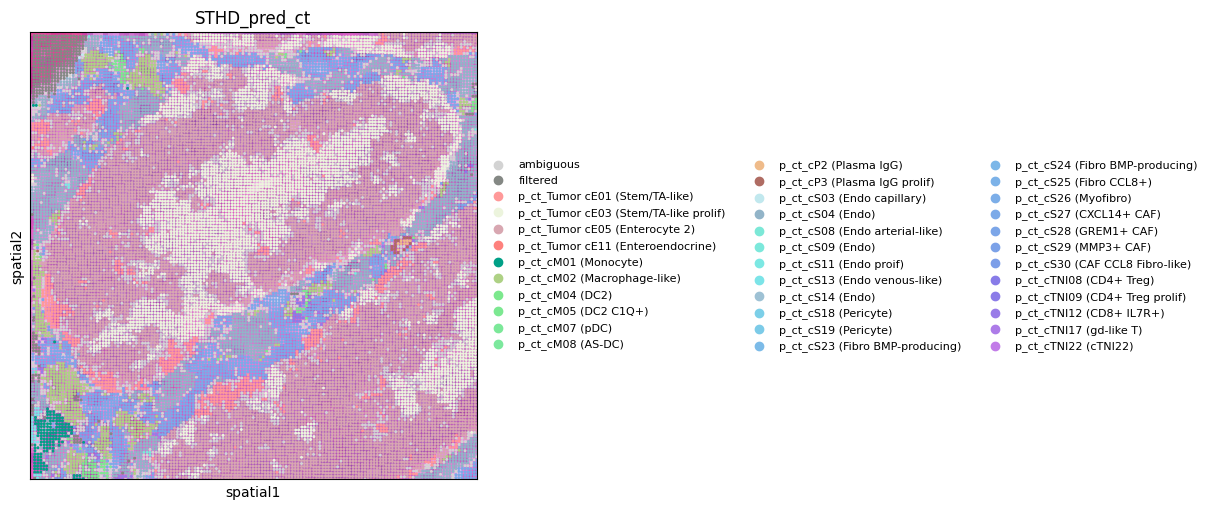

In [ ]:
cmap = color_palette.get_config_colormap( name = 'colormap_coloncatlas_98')
data_palette = color_palette.prepare_palette(cmap, sthdata.adata)

sq.pl.spatial_scatter(
    sthdata.adata,
    color='STHD_pred_ct',
    crop_coord = [sthdata.get_sequencing_data_region()],
    legend_fontsize=8,
    palette = data_palette,
    figsize=(12,12)
)

In [24]:
sthdata.adata

AnnData object with n_obs × n_vars = 22336 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'p_ct_Tumor cE01 (Stem/TA-like)', 'p_ct_Tumor cE02 (Stem/TA-like/Immature Goblet)', 'p_ct_Tumor cE03 (Stem/TA-like prolif)', 'p_ct_Tumor cE04 (Enterocyte 1)', 'p_ct_Tumor cE05 (Enterocyte 2)', 'p_ct_Tumor cE06 (Immature Goblet)', 'p_ct_Tumor cE07 (Goblet/Enterocyte)', 'p_ct_Tumor cE08 (Goblet)', 'p_ct_Tumor cE09 (Best4)', 'p_ct_Tumor cE10 (Tuft)', 'p_ct_Tumor cE11 (Enteroendocrine)', 'p_ct_cB1 (B IGD+IgM+)', 'p_ct_cB2 (B GC-like)', 'p_ct_cB3 (B CD40+ GC-like)', 'p_ct_cE01 (Stem/TA-like)', 'p_ct_cE02 (Stem/TA-like/Immature Goblet)', 'p_ct_cE03 (Stem/TA-like prolif)', 'p_ct_cE04 (Enterocyte 1)', 'p_ct_cE05 (Enterocyte 2)', 'p_ct_cE06 (Immature Goblet)', 'p_ct_cE07 (Goblet/Enterocyte)', 'p_ct_cE08 (Goblet)', 'p_ct_cE09 (Best4)', 'p_ct_cE10 (Tuft)', 'p_ct_cE11 (Enteroendocrine)', 'p_ct_cM01 (Monocyte)', 'p_ct_cM02 (Macrophage-like)', 'p_ct_cM03 (DC1)', 'p_ct_cM04 (DC2)', 'p_ct_cM0

# 4. STHDviewer

Advantages compared to traditional scatter plot : 
- Highly optimized for handling millions of points
- Fast and scalable
- Interactive (zoom, pan, selection)
- Results are portable as html files.

In [14]:
from STHD import color_palette
from STHD import sthdviz
from STHD import train

In [15]:
# the training results can be also loaded by the following function
#patch_path = '../testdata/crop10'
#sthdata = train.load_data_with_pdata(file_path = patch_path)

In [16]:
df = sthdata.adata.obs[['array_row', 'array_col', 'STHD_pred_ct']]
df_rasterize = sthdviz.rasterize(df, 'STHD_pred_ct')
sthdviz.fast_plot(
    df_rasterize, 
    title = 'STHDviewer_testpatch',
    save_root_dir = '../output'
)

1816.0 1966.0 151
2119.0 2269.0 151


  0%|          | 0/22336 [00:00<?, ?it/s]

convert cell types to numerical representations: 100%|██████████| 151/151 [00:00<00:00, 4878.90it/s]


# 5. STHD-guided binning

- If nspot = 4 : 4x4 spots ; each spot 2x2um -> 8x8um bin
- If nspot = 8 : 8x8 spots ; each spot 2x2um -> 16x16um bin

In [17]:
from STHD import binning_fast
binadata = binning_fast.get_sthd_guided_bin_adata(sthdata, pred_col = 'STHD_pred_ct', nspot=4)

  0%|          | 0/22336 [00:00<?, ?it/s]

100%|██████████| 22336/22336 [00:00<00:00, 197251.43it/s]


[LOG] Calculating each bin's sum values


100%|██████████| 3657/3657 [00:01<00:00, 1953.94it/s]


[LOG] Constructing adata.X as a sparse matrix


100%|██████████| 3657/3657 [00:00<00:00, 140624.06it/s]


[Log] binning obs...


100%|██████████| 3657/3657 [00:00<00:00, 6765.04it/s]


[Log] binning obsm...


100%|██████████| 3657/3657 [00:00<00:00, 82054.71it/s]


[Log] remove classes to be filtered out...
[Log] filter minimum spot number...
AnnData object with n_obs × n_vars = 2043 × 18085
    obs: 'bin_row', 'bin_col', 'STHD_pred_ct', 'barcodes_included', 'n_counts', 'bin_n_spot'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'STHD_pred_ct_colors'
    obsm: 'spatial'


/hpc/group/yizhanglab/zs144/repo/Zion-STHD/notebooks/../STHD/binning_fast.py:388: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  binadata.obs["barcodes_included"] = binadata.obs["barcodes_included"].str.join(


In [18]:
binadata

AnnData object with n_obs × n_vars = 2043 × 18085
    obs: 'bin_row', 'bin_col', 'STHD_pred_ct', 'barcodes_included', 'n_counts', 'bin_n_spot'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'STHD_pred_ct_colors'
    obsm: 'spatial'

In [19]:
binadata.obs

,bin_row,bin_col,STHD_pred_ct,barcodes_included,n_counts,bin_n_spot
1852||2179||p_ct_cS27 (CXCL14+ CAF),1852,2179,p_ct_cS27 (CXCL14+ CAF),"s_002um_01855_02181-1,s_002um_01854_02181-1,s_...",404.0,14
1820||2259||p_ct_cS27 (CXCL14+ CAF),1820,2259,p_ct_cS27 (CXCL14+ CAF),"s_002um_01822_02261-1,s_002um_01821_02262-1,s_...",169.0,10
1888||2171||p_ct_Tumor cE03 (Stem/TA-like prolif),1888,2171,p_ct_Tumor cE03 (Stem/TA-like prolif),"s_002um_01891_02172-1,s_002um_01890_02174-1,s_...",1070.0,15
1920||2251||p_ct_Tumor cE05 (Enterocyte 2),1920,2251,p_ct_Tumor cE05 (Enterocyte 2),"s_002um_01921_02251-1,s_002um_01920_02251-1,s_...",511.0,7
1912||2227||p_ct_Tumor cE05 (Enterocyte 2),1912,2227,p_ct_Tumor cE05 (Enterocyte 2),"s_002um_01913_02230-1,s_002um_01912_02229-1,s_...",778.0,15
...,...,...,...,...,...,...
1904||2199||p_ct_Tumor cE05 (Enterocyte 2),1904,2199,p_ct_Tumor cE05 (Enterocyte 2),"s_002um_01907_02199-1,s_002um_01905_02199-1",200.0,2
1936||2163||p_ct_Tumor cE01 (Stem/TA-like),1936,2163,p_ct_Tumor cE01 (Stem/TA-like),"s_002um_01937_02163-1,s_002um_01936_02166-1",150.0,2
1840||2255||p_ct_Tumor cE03 (Stem/TA-like prolif),1840,2255,p_ct_Tumor cE03 (Stem/TA-like prolif),"s_002um_01843_02258-1,s_002um_01843_02257-1",187.0,2
1960||2219||p_ct_cS27 (CXCL14+ CAF),1960,2219,p_ct_cS27 (CXCL14+ CAF),"s_002um_01960_02219-1,s_002um_01961_02219-1",79.0,2


In [46]:
binadata.obs.bin_row

1852||2179||p_ct_cS27 (CXCL14+ CAF)                  1852
1820||2259||p_ct_cS27 (CXCL14+ CAF)                  1820
1888||2171||p_ct_Tumor cE03 (Stem/TA-like prolif)    1888
1920||2251||p_ct_Tumor cE05 (Enterocyte 2)           1920
1912||2227||p_ct_Tumor cE05 (Enterocyte 2)           1912
                                                     ... 
1904||2199||p_ct_Tumor cE05 (Enterocyte 2)           1904
1936||2163||p_ct_Tumor cE01 (Stem/TA-like)           1936
1840||2255||p_ct_Tumor cE03 (Stem/TA-like prolif)    1840
1960||2219||p_ct_cS27 (CXCL14+ CAF)                  1960
1932||2215||p_ct_Tumor cE03 (Stem/TA-like prolif)    1932
Name: bin_row, Length: 2043, dtype: category
Categories (38, object): ['1816', '1820', '1824', '1828', ..., '1952', '1956', '1960', '1964']

In [44]:
binadata.obsm["spatial"]

array([[56692.57142857,  9054.21428571],
       [57279.5       ,  9298.6       ],
       [56639.26666667,  8792.86666667],
       ...,
       [57254.5       ,  9140.        ],
       [56985.        ,  8278.5       ],
       [56964.        ,  8482.5       ]])

In [27]:
sthdata.adata

AnnData object with n_obs × n_vars = 22336 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'p_ct_Tumor cE01 (Stem/TA-like)', 'p_ct_Tumor cE02 (Stem/TA-like/Immature Goblet)', 'p_ct_Tumor cE03 (Stem/TA-like prolif)', 'p_ct_Tumor cE04 (Enterocyte 1)', 'p_ct_Tumor cE05 (Enterocyte 2)', 'p_ct_Tumor cE06 (Immature Goblet)', 'p_ct_Tumor cE07 (Goblet/Enterocyte)', 'p_ct_Tumor cE08 (Goblet)', 'p_ct_Tumor cE09 (Best4)', 'p_ct_Tumor cE10 (Tuft)', 'p_ct_Tumor cE11 (Enteroendocrine)', 'p_ct_cB1 (B IGD+IgM+)', 'p_ct_cB2 (B GC-like)', 'p_ct_cB3 (B CD40+ GC-like)', 'p_ct_cE01 (Stem/TA-like)', 'p_ct_cE02 (Stem/TA-like/Immature Goblet)', 'p_ct_cE03 (Stem/TA-like prolif)', 'p_ct_cE04 (Enterocyte 1)', 'p_ct_cE05 (Enterocyte 2)', 'p_ct_cE06 (Immature Goblet)', 'p_ct_cE07 (Goblet/Enterocyte)', 'p_ct_cE08 (Goblet)', 'p_ct_cE09 (Best4)', 'p_ct_cE10 (Tuft)', 'p_ct_cE11 (Enteroendocrine)', 'p_ct_cM01 (Monocyte)', 'p_ct_cM02 (Macrophage-like)', 'p_ct_cM03 (DC1)', 'p_ct_cM04 (DC2)', 'p_ct_cM0

In [42]:
sthdata.adata.obs

,in_tissue,array_row,array_col,n_counts,p_ct_Tumor cE01 (Stem/TA-like),p_ct_Tumor cE02 (Stem/TA-like/Immature Goblet),p_ct_Tumor cE03 (Stem/TA-like prolif),p_ct_Tumor cE04 (Enterocyte 1),p_ct_Tumor cE05 (Enterocyte 2),p_ct_Tumor cE06 (Immature Goblet),...,p_ct_cTNI20 (PLZF+ T),p_ct_cTNI21 (PLZF+ T prolif),p_ct_cTNI22 (cTNI22),p_ct_cTNI23 (NK CD16A+),p_ct_cTNI24 (NK GZMK+),p_ct_cTNI25 (NK XCL1+),p_ct_cTNI26 (ILC3),x,y,STHD_pred_ct
s_002um_01855_02181-1,1.0,1855.0,2181.0,26.0,2.524804e-12,2.749802e-12,2.635921e-12,3.606381e-12,2.689957e-12,3.209214e-12,...,2.517834e-12,2.590325e-12,2.925126e-12,2.729780e-11,2.769504e-12,3.227901e-12,2.699842e-12,56697.0,9045.0,p_ct_cS27 (CXCL14+ CAF)
s_002um_01822_02261-1,1.0,1822.0,2261.0,10.0,1.035372e-11,1.007570e-11,1.252995e-11,1.062735e-11,1.902098e-11,1.027349e-11,...,7.116005e-12,6.970311e-12,8.323488e-12,8.883248e-12,6.600353e-12,1.638529e-11,4.312619e-11,57278.0,9293.0,p_ct_cS27 (CXCL14+ CAF)
s_002um_01913_02137-1,1.0,1913.0,2137.0,112.0,5.116652e-01,6.323568e-05,4.808107e-03,2.676648e-09,4.834380e-01,1.023392e-07,...,1.212507e-11,1.588165e-11,1.113779e-11,1.289147e-11,1.314130e-11,8.562041e-12,3.648399e-11,56382.0,8617.0,ambiguous
s_002um_01891_02172-1,1.0,1891.0,2172.0,45.0,3.783439e-03,1.099894e-04,9.803300e-01,1.568678e-08,1.575378e-02,4.758891e-08,...,8.580873e-12,1.073403e-11,1.868611e-11,2.026168e-11,1.384607e-11,5.800406e-12,1.548935e-10,56635.0,8781.0,p_ct_Tumor cE03 (Stem/TA-like prolif)
s_002um_01921_02251-1,1.0,1921.0,2251.0,73.0,1.226484e-03,3.013767e-05,7.480894e-03,2.226815e-07,9.912437e-01,3.670030e-08,...,1.428024e-10,2.193465e-10,1.521024e-11,1.749740e-11,1.268868e-11,2.116777e-11,1.723773e-10,57215.0,8570.0,p_ct_Tumor cE05 (Enterocyte 2)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_002um_01910_02184-1,1.0,1910.0,2184.0,51.0,4.776455e-03,8.322250e-05,9.950916e-01,1.865821e-09,1.878191e-05,9.317802e-08,...,6.526693e-12,5.397715e-12,2.052159e-12,7.050637e-12,4.079364e-12,3.034526e-12,3.877590e-11,56724.0,8644.0,p_ct_Tumor cE03 (Stem/TA-like prolif)
s_002um_01826_02180-1,1.0,1826.0,2180.0,25.0,2.305733e-02,4.848415e-03,6.158466e-01,8.249102e-07,3.561216e-01,1.802193e-06,...,1.006461e-11,1.175754e-11,7.740107e-12,7.931960e-12,8.348556e-12,8.423203e-12,1.124345e-11,56687.0,9256.0,ambiguous
s_002um_01864_02167-1,1.0,1864.0,2167.0,49.0,3.548717e-01,1.104772e-04,6.310402e-01,1.415492e-07,1.394028e-02,4.348276e-08,...,1.944439e-11,1.687304e-11,5.860405e-12,9.295354e-12,1.343886e-11,2.860901e-11,2.572884e-07,56596.0,8978.0,ambiguous
s_002um_01840_02190-1,1.0,1840.0,2190.0,25.0,1.148482e-04,6.283097e-06,9.243648e-05,1.201973e-06,9.997690e-01,1.581105e-07,...,3.945782e-11,7.889442e-11,4.871712e-10,2.284414e-09,4.941917e-10,7.951964e-10,7.754050e-10,56762.0,9155.0,p_ct_Tumor cE05 (Enterocyte 2)


In [41]:
sthdata.adata.obsm["spatial"]

array([[56697.,  9045.],
       [57278.,  9293.],
       [56382.,  8617.],
       ...,
       [56596.,  8978.],
       [56762.,  9155.],
       [56465.,  8910.]])

In [43]:
sthdata.get_sequencing_data_region()

(56250, 8240, 57340, 9330)

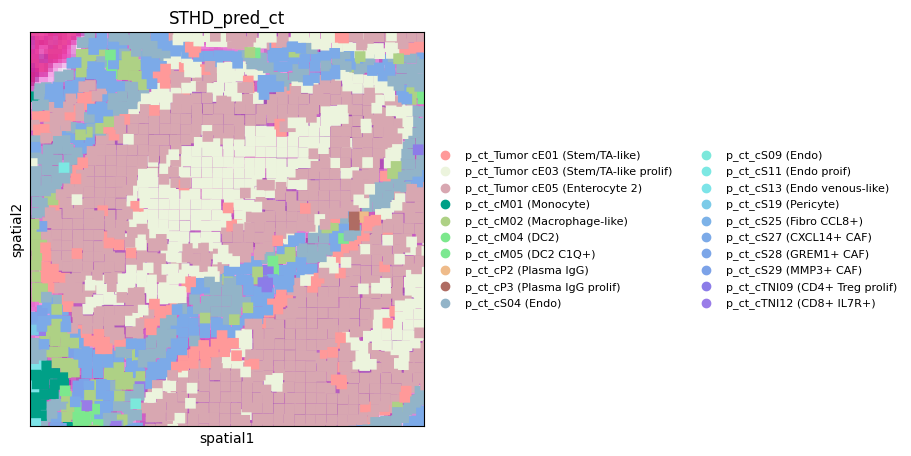

In [38]:
cmap = color_palette.get_config_colormap(name='colormap_coloncatlas_98')
data_palette = color_palette.prepare_palette(cmap, binadata)

sq.pl.spatial_scatter(
    binadata,
    size=4,
    shape='square',
    color='STHD_pred_ct',
    crop_coord=[sthdata.get_sequencing_data_region()],
    legend_fontsize=8,
    palette=data_palette,
    figsize=(9,9)
)